In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
train_df = pd.read_csv("train (1).csv")
test_df = pd.read_csv("test (1).csv")
X = train_df.iloc[:, 1:].values  # Pixel values (784 columns)
y = train_df.iloc[:, 0].values   # Labels
X = X.reshape(-1, 28, 28)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test = test_df.iloc[:, 1:].values.reshape(-1, 28, 28)
y_test = test_df.iloc[:, 0].values
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
batch_size = 64 # Number of samples per batch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
label_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}
y_train_words = np.array([label_map[label] for label in y_train])
y_val_words = np.array([label_map[label] for label in y_val])
print(y_train_words)
print(y_val_words)

['Sandal' 'Sneaker' 'Bag' ... 'Ankle boot' 'Coat' 'T-shirt/top']
['Sneaker' 'Bag' 'Bag' ... 'Ankle boot' 'Sandal' 'Sandal']


Model 1: Flattened raw images (1D vector) without any additional preprocessing.

In [ ]:

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu    = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
import torch.nn as nn
from tqdm import tqdm

class Trainer():
    def __init__(self, model, train_loader, test_loader, optimizer, criterion=nn.CrossEntropyLoss()):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.criterion = criterion

    def train_epoch(self, epochs=10):
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            train_acc = 0.0

            train_progress_bar = tqdm(self.train_loader, total=len(self.train_loader), desc=f"Epoch {epoch+1}/{epochs}")
            for data, target in train_progress_bar:
                data, target = data.to(device), target.to(device)
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_acc += (output.argmax(dim=1) == target).float().mean().item()

                train_progress_bar.set_postfix(Loss=train_loss / len(self.train_loader), Accuracy=train_acc / len(self.train_loader))

            train_losses.append(train_loss / len(self.train_loader))
            train_accuracies.append(train_acc / len(self.train_loader))

            val_metrics = self.test_epoch(epoch, epochs)
            val_losses.append(val_metrics["val_loss"])
            val_accuracies.append(val_metrics["val_acc"])
            print()

        return {
            "train_loss": train_losses,
            "train_acc": train_accuracies,
            "val_loss": val_losses,
            "val_acc": val_accuracies
        }

    def test_epoch(self, epoch=None, epochs=None):
        self.model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            test_progress_bar = tqdm(self.test_loader, total=len(self.test_loader), desc=f"Epoch {epoch+1}/{epochs} - Test")
            for data, target in test_progress_bar:
                data, target = data.to(device), target.to(device)
                output = self.model(data)
                loss = self.criterion(output, target)
                val_loss += loss.item()
                val_acc += (output.argmax(dim=1) == target).float().mean().item()

                test_progress_bar.set_postfix(Loss=val_loss / len(self.test_loader), Accuracy=val_acc / len(self.test_loader))

        return {
            "val_loss": val_loss / len(self.test_loader),
            "val_acc": val_acc / len(self.test_loader)
        }

    def predict(self, data):
        self.model.eval()
        with torch.no_grad():
            output = self.model(data.to(device))
            pred = output.argmax(dim=1)
        return pred

    def evaluate(self, test_loader):
        self.model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data = data.to(device)
                output = self.model(data)
                predictions = output.argmax(dim=1).cpu().numpy()
                y_true.extend(target.numpy())
                y_pred.extend(predictions)
        return y_true, y_pred




wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pratyswain (pratyswain-Amrita Vishwa Vidyapeetham) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/15 - Test: 100%|██████████| 188/188 [00:01<00:00, 149.59it/s, Accuracy=0.794, Loss=0.567]


Epoch 2/15 - Test: 100%|██████████| 188/188 [00:01<00:00, 187.27it/s, Accuracy=0.833, Loss=0.481]


Epoch 3/15 - Test: 100%|██████████| 188/188 [00:00<00:00, 207.66it/s, Accuracy=0.819, Loss=0.494]


Epoch 4/15 - Test: 100%|██████████| 188/188 [00:01<00:00, 168.52it/s, Accuracy=0.84, Loss=0.451]


Epoch 5/15 - Test: 100%|██████████| 188/188 [00:00<00:00, 191.80it/s, Accuracy=0.843, Loss=0.443]


Epoch 6/15 - Test: 100%|██████████| 188/188 [00:01<00:00, 172.33it/s, Accuracy=0.852, Loss=0.419]


Epoch 7/15 - Test: 100%|██████████| 188/188 [00:00<00:00, 191.06it/s, Accuracy=0.847, Loss=0.427]


Epoch 8/15 - Test: 100%|██████████| 188/188 [00:01<00:00, 186.12it/s, Accuracy=0.844, Loss=0.437]


Epoch 9/15 - Test: 100%|██████████| 188/188 [00:01<00:00, 108.88it/s, Accuracy=0.846, Loss=0.426]


Epoch 10/15 - Test: 100%|██████████| 188/188 [00:01<00:00, 133.15it/s, Accuracy=0.857, Loss=0.407]


Epoch 11/15 - Test: 100%|██████████| 188/188 [00:01<00:00, 126.43it/s, Accuracy=0.853, Loss=0.421]


Epoch 12/15 - Test: 100%|██████████| 188/188 [00:00<00:00, 209.56it/s, Accuracy=0.823, Loss=0.448]


Epoch 13/15 - Test: 100%|██████████| 188/188 [00:01<00:00, 178.49it/s, Accuracy=0.861, Loss=0.401]


Epoch 14/15 - Test: 100%|██████████| 188/188 [00:01<00:00, 186.34it/s, Accuracy=0.855, Loss=0.413]


Epoch 15/15 - Test: 100%|██████████| 188/188 [00:00<00:00, 190.74it/s, Accuracy=0.853, Loss=0.419]


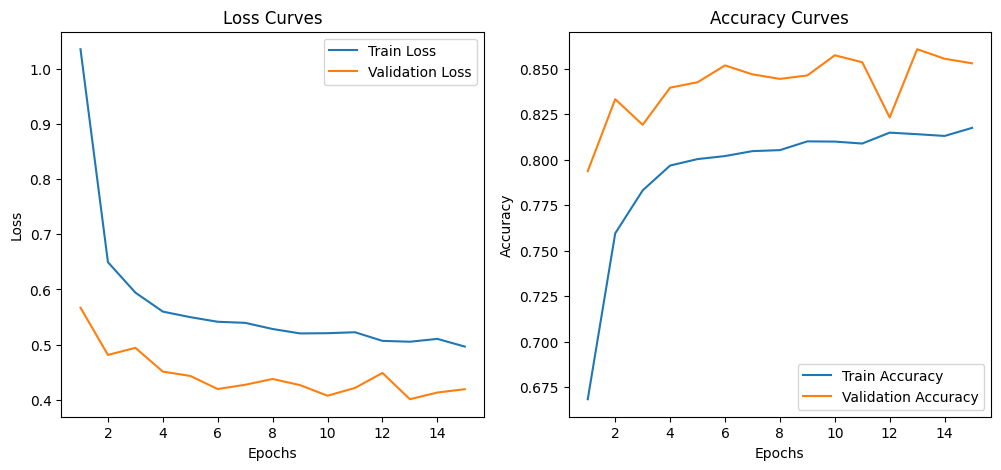

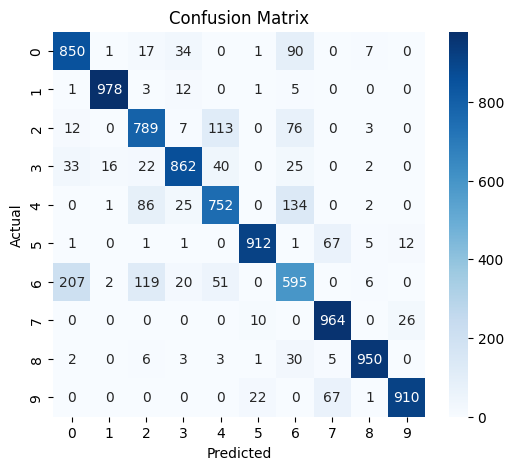

Accuracy,▁
F1-Score,▁
Precision,▁
Recall,▁
Accuracy,0.8562
F1-Score,0.8562
Precision,0.8576
Recall,0.8562


In [ ]:


import torch
import torch.optim as optim
import wandb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize wandb
wandb.init(project="model-training", name="LeNet-Training")

model = LeNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, train_loader, val_loader, optimizer)

history = trainer.train_epoch(epochs=15)

epochs = range(1, len(history['train_loss']) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(epochs, history['train_loss'], label='Train Loss')
ax[0].plot(epochs, history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss Curves')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, history['train_acc'], label='Train Accuracy')
ax[1].plot(epochs, history['val_acc'], label='Validation Accuracy')
ax[1].set_title('Accuracy Curves')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

wandb.log({"Loss Curves": wandb.Image(fig)})
plt.show()

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    # Log metrics
    wandb.log({
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    wandb.log({"Confusion Matrix": wandb.Image(plt)})
    plt.show()

    return acc, precision, recall, f1

# Run evaluation
evaluate_model(model, test_loader)

# Finish wandb run
wandb.finish()

Epoch 1/20 - Test: 100%|██████████| 375/375 [00:05<00:00, 68.23it/s, Accuracy=0.825, Loss=0.476]


Epoch 2/20 - Test: 100%|██████████| 375/375 [00:03<00:00, 115.27it/s, Accuracy=0.837, Loss=0.445]


Epoch 3/20 - Test: 100%|██████████| 375/375 [00:04<00:00, 75.43it/s, Accuracy=0.849, Loss=0.409] 


Epoch 4/20 - Test: 100%|██████████| 375/375 [00:03<00:00, 116.85it/s, Accuracy=0.848, Loss=0.415]


Epoch 5/20 - Test: 100%|██████████| 375/375 [00:03<00:00, 104.41it/s, Accuracy=0.851, Loss=0.406]


Epoch 6/20 - Test: 100%|██████████| 375/375 [00:03<00:00, 112.97it/s, Accuracy=0.859, Loss=0.401]


Epoch 7/20 - Test: 100%|██████████| 375/375 [00:03<00:00, 93.82it/s, Accuracy=0.855, Loss=0.408] 


Epoch 8/20 - Test: 100%|██████████| 375/375 [00:04<00:00, 81.76it/s, Accuracy=0.855, Loss=0.42]


Epoch 9/20 - Test: 100%|██████████| 375/375 [00:03<00:00, 117.21it/s, Accuracy=0.857, Loss=0.443]


Epoch 10/20 - Test: 100%|██████████| 375/375 [00:03<00:00, 114.25it/s, Accuracy=0.859, Loss=0.442]


Epoch 11/20 - Test: 100%|██████████| 375/375 [00:03<00:00, 95.73it/s, Accuracy=0.859, Loss=0.444] 


Epoch 12/20 - Test: 100%|██████████| 375/375 [00:03<00:00, 110.75it/s, Accuracy=0.857, Loss=0.458]


Epoch 13/20 - Test: 100%|██████████| 375/375 [00:03<00:00, 111.91it/s, Accuracy=0.853, Loss=0.479]


Epoch 14/20 - Test: 100%|██████████| 375/375 [00:05<00:00, 68.44it/s, Accuracy=0.856, Loss=0.478]


Epoch 15/20 - Test: 100%|██████████| 375/375 [00:03<00:00, 107.23it/s, Accuracy=0.854, Loss=0.504]


Epoch 16/20 - Test: 100%|██████████| 375/375 [00:03<00:00, 109.76it/s, Accuracy=0.858, Loss=0.5]


Epoch 17/20 - Test: 100%|██████████| 375/375 [00:04<00:00, 85.03it/s, Accuracy=0.858, Loss=0.521]


Epoch 18/20 - Test: 100%|██████████| 375/375 [00:03<00:00, 110.55it/s, Accuracy=0.854, Loss=0.526]


Epoch 19/20 - Test: 100%|██████████| 375/375 [00:04<00:00, 82.12it/s, Accuracy=0.851, Loss=0.544] 


Epoch 20/20 - Test: 100%|██████████| 375/375 [00:03<00:00, 109.46it/s, Accuracy=0.857, Loss=0.544]


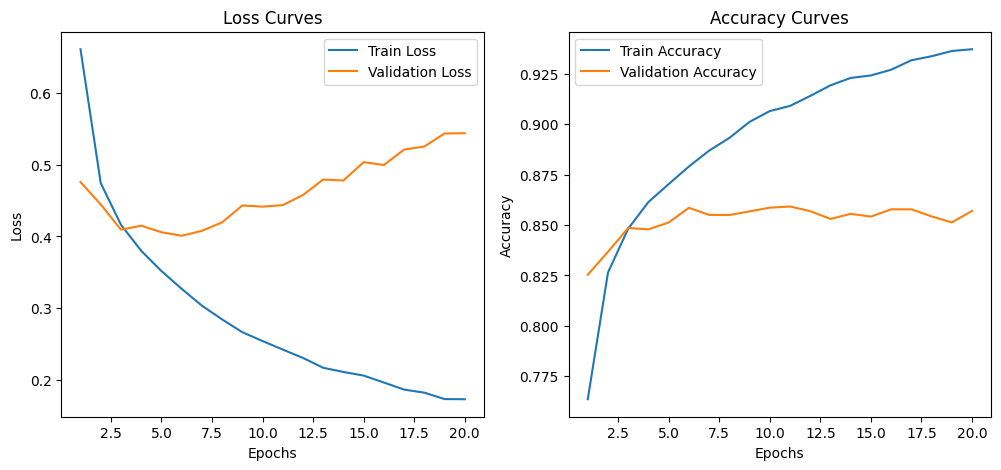

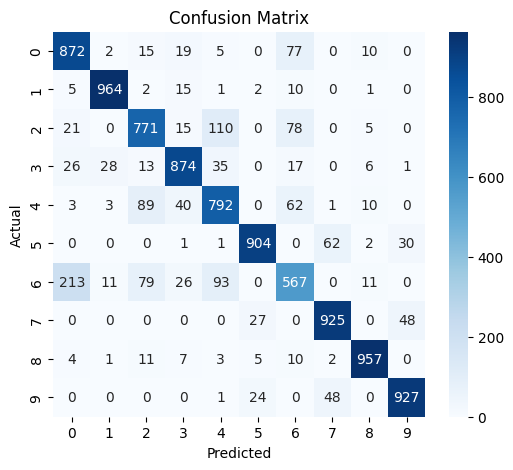

Accuracy,▁
F1-Score,▁
Precision,▁
Recall,▁
Accuracy,0.8553
F1-Score,0.85356
Precision,0.85398
Recall,0.8553


In [ ]:

import cv2
import numpy as np
import torch
import torch.optim as optim
import wandb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize wandb
wandb.init(project="model-training", name="LeNet-Training")

class PreprocessDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        img = cv2.Canny(img.astype(np.uint8), 50, 150)  # or put thresholds (100, 200)
        img = img.astype(np.float32) / 255.0
        img = torch.tensor(img).unsqueeze(0)

        if self.y is not None:
            label = self.y[idx]
            return img, label
        return img

train_dataset = PreprocessDataset(X_train, y_train)
val_dataset = PreprocessDataset(X_val, y_val)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = PreprocessDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

model = LeNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, train_loader, val_loader, optimizer)

history = trainer.train_epoch(epochs=20)

epochs = range(1, len(history['train_loss']) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(epochs, history['train_loss'], label='Train Loss')
ax[0].plot(epochs, history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss Curves')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, history['train_acc'], label='Train Accuracy')
ax[1].plot(epochs, history['val_acc'], label='Validation Accuracy')
ax[1].set_title('Accuracy Curves')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

wandb.log({"Loss Curves": wandb.Image(fig)})
plt.show()

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    # Log metrics
    wandb.log({
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    wandb.log({"Confusion Matrix": wandb.Image(plt)})
    plt.show()

    return acc, precision, recall, f1

# Run evaluation
evaluate_model(model, test_loader)

# Finish wandb run
wandb.finish()

Epoch 1/20 - Test: 100%|██████████| 375/375 [00:16<00:00, 22.48it/s, Accuracy=0.795, Loss=0.551]


Epoch 2/20 - Test: 100%|██████████| 375/375 [00:16<00:00, 22.58it/s, Accuracy=0.813, Loss=0.492]


Epoch 3/20 - Test: 100%|██████████| 375/375 [00:17<00:00, 22.02it/s, Accuracy=0.814, Loss=0.482]


Epoch 4/20 - Test: 100%|██████████| 375/375 [00:16<00:00, 22.12it/s, Accuracy=0.824, Loss=0.461]


Epoch 5/20 - Test: 100%|██████████| 375/375 [00:16<00:00, 22.27it/s, Accuracy=0.829, Loss=0.452]


Epoch 6/20 - Test: 100%|██████████| 375/375 [00:16<00:00, 22.23it/s, Accuracy=0.838, Loss=0.435]


Epoch 7/20 - Test: 100%|██████████| 375/375 [00:18<00:00, 20.62it/s, Accuracy=0.84, Loss=0.426]


Epoch 8/20 - Test: 100%|██████████| 375/375 [00:16<00:00, 22.61it/s, Accuracy=0.842, Loss=0.424]


Epoch 9/20 - Test: 100%|██████████| 375/375 [00:16<00:00, 22.13it/s, Accuracy=0.846, Loss=0.414]


Epoch 10/20 - Test: 100%|██████████| 375/375 [00:16<00:00, 22.29it/s, Accuracy=0.844, Loss=0.413]


Epoch 11/20 - Test: 100%|██████████| 375/375 [00:18<00:00, 20.72it/s, Accuracy=0.844, Loss=0.41]


Epoch 12/20 - Test: 100%|██████████| 375/375 [00:17<00:00, 22.02it/s, Accuracy=0.85, Loss=0.409]


Epoch 13/20 - Test: 100%|██████████| 375/375 [00:17<00:00, 22.01it/s, Accuracy=0.852, Loss=0.404]


Epoch 14/20 - Test: 100%|██████████| 375/375 [00:18<00:00, 20.26it/s, Accuracy=0.851, Loss=0.401]


Epoch 15/20 - Test: 100%|██████████| 375/375 [00:17<00:00, 21.96it/s, Accuracy=0.853, Loss=0.395]


Epoch 16/20 - Test: 100%|██████████| 375/375 [00:16<00:00, 22.13it/s, Accuracy=0.852, Loss=0.395]


Epoch 17/20 - Test: 100%|██████████| 375/375 [00:16<00:00, 22.15it/s, Accuracy=0.854, Loss=0.392]


Epoch 18/20 - Test: 100%|██████████| 375/375 [00:18<00:00, 20.72it/s, Accuracy=0.853, Loss=0.394]


Epoch 19/20 - Test: 100%|██████████| 375/375 [00:18<00:00, 20.53it/s, Accuracy=0.852, Loss=0.393]


Epoch 20/20 - Test: 100%|██████████| 375/375 [00:16<00:00, 22.20it/s, Accuracy=0.856, Loss=0.39]


F1-Score,▁
Precision,▁
Recall,▁
Test Accuracy,▁
F1-Score,0.86523
Precision,0.86508
Recall,0.866
Test Accuracy,0.866


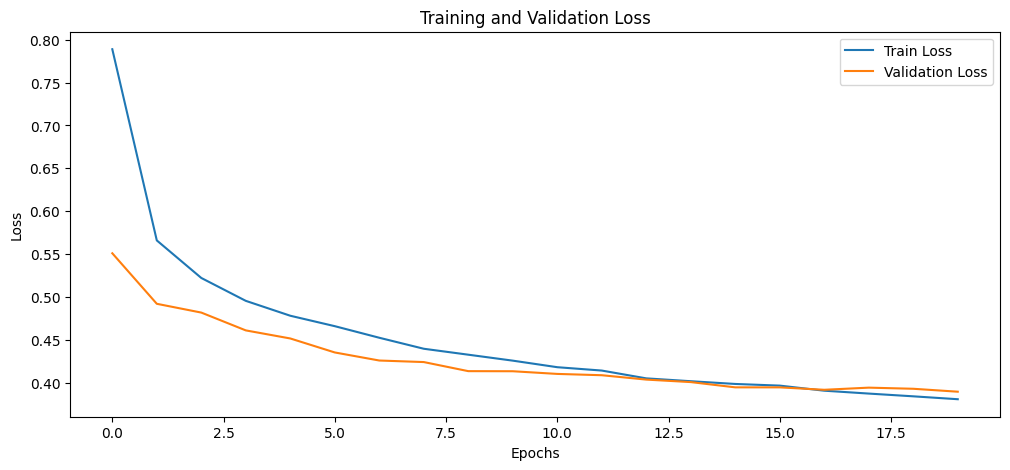

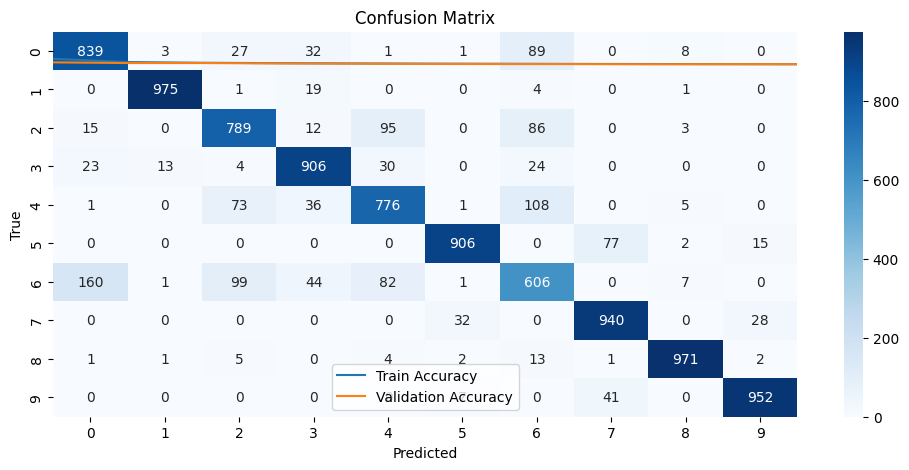

In [ ]:


import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader

# Initialize wandb
wandb.init(project="model-training", name="HOGNet-Training")

# HOG Feature Extractor
class HOGFeatureExtractor:
    def __init__(self, cell_size=8, block_size=2, bins=9):
        self.cell_size = cell_size
        self.block_size = block_size
        self.bins = bins

    def compute_hog(self, image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image.astype(np.float32)
        grad_x = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=1)
        grad_y = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=1)
        magnitude, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)
        angle[angle >= 180] -= 180
        return self._compute_histogram(magnitude, angle)

    def _compute_histogram(self, magnitude, angle):
        height, width = magnitude.shape
        cell_h, cell_w = self.cell_size, self.cell_size
        block_h, block_w = self.block_size, self.block_size
        n_cells_x, n_cells_y = width // cell_w, height // cell_h
        hist_bins = np.zeros((n_cells_y, n_cells_x, self.bins))
        for i in range(n_cells_y):
            for j in range(n_cells_x):
                mag_cell = magnitude[i * cell_h:(i + 1) * cell_h, j * cell_w:(j + 1) * cell_w]
                ang_cell = angle[i * cell_h:(i + 1) * cell_h, j * cell_w:(j + 1) * cell_w]
                hist, _ = np.histogram(ang_cell, bins=self.bins, range=(0, 180), weights=mag_cell)
                hist_bins[i, j, :] = hist
        blocks = []
        for i in range(n_cells_y - block_h + 1):
            for j in range(n_cells_x - block_w + 1):
                block = hist_bins[i:i + block_h, j:j + block_w, :].flatten()
                norm = np.linalg.norm(block, ord=2)
                block = block / (norm + 1e-6)
                blocks.append(block)
        return np.hstack(blocks)
    def evaluate(self, dataloader):
        self.model.eval()
        y_true, y_pred = [], []

        with torch.no_grad():
            for data in dataloader:
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                predictions = torch.argmax(outputs, dim=1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predictions.cpu().numpy())

        return y_true, y_pred

class PreprocessHOGDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y
        self.hog_extractor = HOGFeatureExtractor()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        hog_features = self.hog_extractor.compute_hog(img)
        hog_features = torch.tensor(hog_features, dtype=torch.float32)
        if self.y is not None:
            return hog_features, self.y[idx]
        return hog_features

train_dataset = PreprocessHOGDataset(X_train, y_train)
val_dataset = PreprocessHOGDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = PreprocessHOGDataset(X_test,y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

sample_hog_features, _ = train_dataset[0]
input_size = sample_hog_features.shape[0]

class HOGNet(nn.Module):
    def __init__(self, input_size):
        super(HOGNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HOGNet(input_size=input_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

trainer = Trainer(model, train_loader, val_loader, optimizer)
history = trainer.train_epoch(epochs=20)

plt.figure(figsize=(12, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig("loss_curve.png")
wandb.log({"Loss Curve": wandb.Image("loss_curve.png")})

plt.figure(figsize=(12, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig("accuracy_curve.png")
wandb.log({"Accuracy Curve": wandb.Image("accuracy_curve.png")})

y_true, y_pred = trainer.evaluate(test_loader)
acc = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix.png")
wandb.log({"Confusion Matrix": wandb.Image("confusion_matrix.png")})

# Log metrics to wandb
wandb.log({"Test Accuracy": acc, "Precision": precision, "Recall": recall, "F1-Score": f1})

# Finish wandb run
wandb.finish()


Model 1: Flattened raw images (1D vector) without any additional preprocessing.
Features Used include The raw grayscale pixel values and there is No explicit feature extraction. The MLP must learn useful patterns. It is used for general use case learning purpose but the performance can increases significantly if we use CNNs instead of normal pure MLP. Accuracy of 85%

Model 2: Edge-detection features i.e
Canny Edge Features include:
Binary edge maps generated using the Canny edge detector.
Emphasizes contours and boundaries of clothing items. It is used for classifying objects where shape(edges) is more important than texture. Input features -> Edge pixels, gradient directions. Accuracy of 85%. Use case of Canny edge detection is detecting edges in high-contrast images

Model 3:HOG Features
Captures local gradient orientations in cells.
Encodes texture and edge directions in a well structured way. It is used when objects where both shape and local texture matter. Input features -> Local shape & gradients. Accuracy of 86%. Use case of HOG features is capturing shape and gradient-based features for object detection

Extracted features that balance discriminability and invariance improve convergence rates while preventing overfitting, whereas poorly chosen features may introduce unnecessary complexity, leading to suboptimal generalization. MLPs can focus on learning particular distinguishable and unique features rather than learning the whole image which will make right use of the resources available and will capture the important distinguishing factors only, this is how feature extraction impacts the MLP's ability to learn and generalize

SIFT features: Detects and describes local features in images that are invariant to scale, rotation, and illumination changes. Identifies keypoints (interest points) and calculates their descriptors based on gradient orientations and value calculated. Input features -> Keypoints & local patterns. Accuracy of 62%. Use case of SIFT features is feature matching, object recognition, and tracking in varying scales/rotations

My conclusion: For fashion mnist, features related to the shape and edges seem to be more helpful for classification

Epoch 1/20, Train Loss: 1.5598, Train Acc: 0.4540, Val Loss: 1.2529, Val Acc: 0.5528
Epoch 2/20, Train Loss: 1.3215, Train Acc: 0.5344, Val Loss: 1.1952, Val Acc: 0.5728
Epoch 3/20, Train Loss: 1.2638, Train Acc: 0.5565, Val Loss: 1.1634, Val Acc: 0.5883
Epoch 4/20, Train Loss: 1.2228, Train Acc: 0.5719, Val Loss: 1.1563, Val Acc: 0.6008
Epoch 5/20, Train Loss: 1.2000, Train Acc: 0.5783, Val Loss: 1.1380, Val Acc: 0.5998
Epoch 6/20, Train Loss: 1.1743, Train Acc: 0.5847, Val Loss: 1.1274, Val Acc: 0.6050
Epoch 7/20, Train Loss: 1.1592, Train Acc: 0.5919, Val Loss: 1.1023, Val Acc: 0.6157
Epoch 8/20, Train Loss: 1.1351, Train Acc: 0.6001, Val Loss: 1.1107, Val Acc: 0.6031
Epoch 9/20, Train Loss: 1.1296, Train Acc: 0.6024, Val Loss: 1.1082, Val Acc: 0.6081
Epoch 10/20, Train Loss: 1.1174, Train Acc: 0.6060, Val Loss: 1.1124, Val Acc: 0.6176
Epoch 11/20, Train Loss: 1.1104, Train Acc: 0.6099, Val Loss: 1.0902, Val Acc: 0.6206
Epoch 12/20, Train Loss: 1.0936, Train Acc: 0.6146, Val Loss: 1

Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
F1-Score,▁
Precision,▁
Recall,▁
Test Accuracy,▁
Train Accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇███████
Train Loss,█▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▃▄▅▅▆▇▆▆▇▇███▇██▇██
Validation Loss,█▆▄▄▃▃▂▂▂▂▁▂▁▁▂▁▁▂▁▁
Epoch,20
F1-Score,0.60958


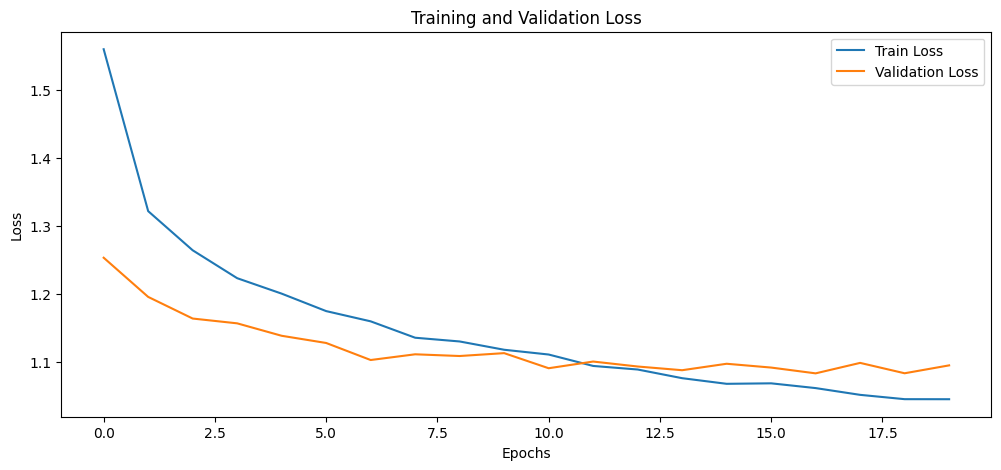

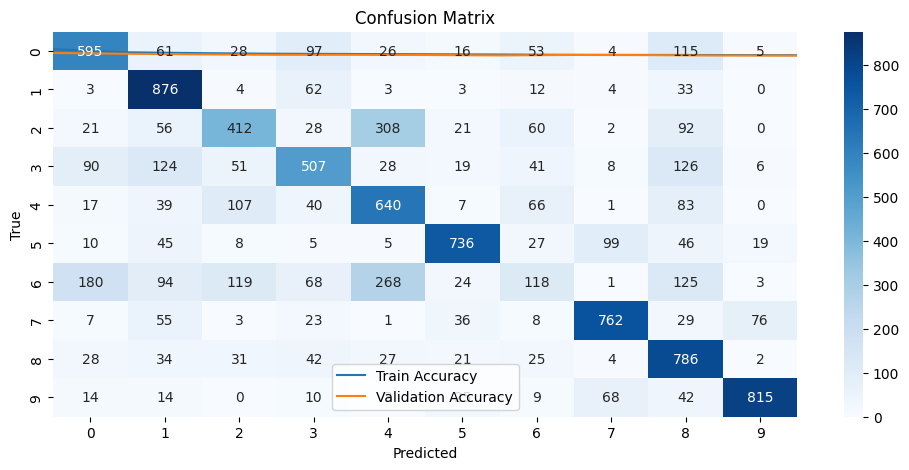

In [ ]:
# SIFT feature extraction
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader

# Initialize wandb
wandb.init(project="model-training", name="SIFTNet-Training")

class SIFTFeatureExtractor:
    def __init__(self, max_features=32):
        self.max_features = max_features
        self.sift = cv2.SIFT_create(nfeatures=max_features)

    def compute_sift(self, image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if image.dtype != np.uint8:
            image = cv2.convertScaleAbs(image)
        keypoints, descriptors = self.sift.detectAndCompute(image, None)

        if descriptors is None:
            return np.zeros(self.max_features * 128)

        descriptors = descriptors.flatten()
        if len(descriptors) > self.max_features * 128:
            descriptors = descriptors[:self.max_features * 128]
        else:
            descriptors = np.pad(descriptors, (0, self.max_features * 128 - len(descriptors)))

        return descriptors


class Trainer:
    def __init__(self, model, train_loader, val_loader, optimizer, device=None):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train_epoch(self, epochs):
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for data in self.train_loader:
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(self.train_loader)
            train_acc = correct / total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)

            val_loss, val_acc = self.validate()
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            wandb.log({
                "Epoch": epoch+1,
                "Train Loss": train_loss,
                "Train Accuracy": train_acc,
                "Validation Loss": val_loss,
                "Validation Accuracy": val_acc
            })

        return history

    def validate(self):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in self.val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(self.val_loader)
        val_acc = correct / total
        return val_loss, val_acc

    def evaluate(self, dataloader):
        self.model.eval()
        y_true, y_pred = [], []

        with torch.no_grad():
            for data in dataloader:
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                predictions = torch.argmax(outputs, dim=1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predictions.cpu().numpy())

        return y_true, y_pred

class PreprocessSIFTDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y
        self.sift_extractor = SIFTFeatureExtractor()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        sift_features = self.sift_extractor.compute_sift(img)
        sift_features = torch.tensor(sift_features, dtype=torch.float32)
        if self.y is not None:
            return sift_features, self.y[idx]
        return sift_features

train_dataset = PreprocessSIFTDataset(X_train, y_train)
val_dataset = PreprocessSIFTDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = PreprocessSIFTDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

sample_sift_features, _ = train_dataset[0]
input_size = sample_sift_features.shape[0]

class SIFTNet(nn.Module):
    def __init__(self, input_size):
        super(SIFTNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SIFTNet(input_size=input_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

trainer = Trainer(model, train_loader, val_loader, optimizer)
history = trainer.train_epoch(epochs=20)

plt.figure(figsize=(12, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig("loss_curve.png")
wandb.log({"Loss Curve": wandb.Image("loss_curve.png")})

plt.figure(figsize=(12, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig("accuracy_curve.png")
wandb.log({"Accuracy Curve": wandb.Image("accuracy_curve.png")})

y_true, y_pred = trainer.evaluate(test_loader)
acc = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix.png")
wandb.log({"Confusion Matrix": wandb.Image("confusion_matrix.png")})

# Log metrics to wandb
wandb.log({"Test Accuracy": acc, "Precision": precision, "Recall": recall, "F1-Score": f1})

# Finish wandb run
wandb.finish()
